# Case Study: NKI

This notebook demonstrates how lensed UMAP can be used to explore the NKI breast cancer gene-expression data set also analysed using Mapper by [Lum et al. (2013)](https://www.nature.com/articles/srep01236/). They identified several genes in the Chemokine KEGG pathway with expression differences between surviving and non-surviving patients with low ESR1 levels. We work through a visual exploration workflow to show how lensed UMAP can be used to reproduce Lum et al.'s findings.

## Setup

First, we load several libraries:

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Data
import numpy as np
import pandas as pd
from anndata import AnnData
from sklearn.impute import KNNImputer
from scipy.stats import kstest

# UMAP
from umap import UMAP
import lensed_umap as lu

# Plotting
import hvplot
import hvplot.pandas  # noqa
import holoviews as hv
from holoviews.selection import link_selections
from _plotting import *

## The data

The [NKI data set](https://doi.org/10.18129/B9.bioc.breastCancerNKI) contains gene expressions and annotations for the observations and features. We load these files into a single [AnnData](https://anndata.readthedocs.io/en/latest/) object to facilitate working with such a structure. After loading the data, we apply the pre-processing steps described in the papers. Our interpretation of these steps may differ from the original work, introducing some differences. For example, genes and observations with many missing values were removed, other missing values were imputed with a `KNNImputer` using $k=5$. In general, though, the result should be comparable. 

In [ ]:
def load_data():
    X = pd.read_csv("./data/nki/nki_exprs.csv").T
    obs = pd.read_csv("./data/nki/nki_obs.csv").drop(
        columns=["samplename", "filename", "pgr", "her2"]
    )
    var = pd.read_csv("./data/nki/nki_var.csv")
    return AnnData(X, obs, var)


def select_and_impute(df):
    missing_mask = np.isnan(df.X)
    missing_per_col = np.sum(missing_mask, axis=0)
    missing_per_row = np.sum(missing_mask, axis=1)
    df = df[:, missing_per_col < np.percentile(missing_per_col, [95])[0]]
    df = df[missing_per_row < np.percentile(missing_per_row, [95])[0], :]
    df.X = KNNImputer(n_neighbors=5, weights="distance").fit_transform(df.X)
    return df


def select_highly_variable(df):
    n_genes = 1553
    variance = np.var(df.X, axis=0)
    threshold = np.partition(variance, -n_genes - 1)[-n_genes - 1]
    return df[:, variance > threshold].copy()

In [ ]:
df = load_data()
df = select_and_impute(df)
df = select_highly_variable(df)
df = df[~df.obs["e.dmfs"].isna(), :].copy()
df.obs["relapsed"] = df.obs["e.dmfs"] == 1
df

AnnData object with n_obs × n_vars = 302 × 1553
    obs: 'dataset', 'series', 'id', 'size', 'age', 'er', 'grade', 'brca.mutation', 'e.dmfs', 't.dmfs', 'node', 't.rfs', 'e.rfs', 'treatment', 'tissue', 't.os', 'e.os', 'relapsed'
    var: 'probe', 'EntrezGene.ID', 'probe.name', 'Alignment.score', 'Length.of.probe', 'NCBI.gene.symbol', 'HUGO.gene.symbol', 'Cytoband', 'Alternative.symbols', 'Description'

## UMAP
A typical exploration starts by constructing and plotting a UMAP model. In this notebook we use [HoloViz](https://holoviz.org/) for interactive plotting (hidden cell):

- `plot_points` colours points with a numerical or categorical dimension.

In [27]:
def plot_points(
    obs,
    colors,
    suffix="base",
    cmap='Blues',
    clim=None,
    colorbar=True,
    cnorm="linear",
    width=300,
    height=300,
):
    """Creates holoviews object for the points layer.
    Uses df.obs for positions and colors."""
    def make_hook(color):
        def legend_hook(plot, element):
            p = plot.handles["plot"]
            if p.legend:
                p.legend.title = color

        return legend_hook

    kdims = [f"{l}_{suffix}" for l in ["x", "y"]]
    return hv.Layout([
        obs.hvplot.points(
            x=kdims[0],
            y=kdims[1],
            color=color,
            colorbar=colorbar,
            clabel=color,
            clim=(obs[color].min(), obs[color].max()) if clim is None else clim,
            cmap=["#ff7f0e", "#1f77b4"] if color == "relapsed" else cmap,
            cnorm=cnorm,
            width=width,
            height=height,
            padding=0.05,
            xaxis=None,
            yaxis=None,
        ).opts(
            legend_position="bottom_left",
            colorbar_opts={"width": 20},
            hooks=[make_hook(color)] if color == "relapsed" else [],
        )
        for color in colors
    ])

The UMAP model is constructed using a correlation distance.

In [25]:
def store_coordinates(df, projector, suffix="base"):
    df.obs[f"x_{suffix}"] = projector.embedding_[:, 0]
    df.obs[f"y_{suffix}"] = projector.embedding_[:, 1]


projector = UMAP(n_neighbors=30, metric="correlation").fit(df.X)
store_coordinates(df, projector, "base")

In [28]:
selector = link_selections.instance(cross_filter_mode="overwrite")
points = plot_points(df.obs, ["relapsed"], suffix="base")
selector(points)

:Layout
   .Points.I :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_base,y_base]   (relapsed)
         .Points.II    :Points   [x_base,y_base]   (relapsed)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]

The resulting graph contains one smaller and one larger community. By selecting the smaller community manually, we can figure out which genes make it differ from the larger community.

In [41]:
# Run after selecting the smaller community
selected_points = selector.filter(df.obs).index
df_sel = df[selected_points]
df_unsel = df[[n not in selected_points for n in df.obs_names]]

Like [Lum et al. (2013)](https://www.nature.com/articles/srep01236/), we perform a Kolmogorov-Smirnov test on each gene to detect which genes distinghuish the communities.

In [30]:
def compare_groups(df1, df2):
    """
    Computes Kolmogorov-Smirnov test between the given populations for each gene.
    Prints named genes from the top-10 most significant.
    """
    Ds, ps = zip(*[kstest(df1.X[:, i], df2.X[:, i]) for i in range(df.shape[1])])

    top_genes = 10
    for idx in np.argpartition(ps, np.arange(top_genes))[:top_genes]:
        name = df.var["HUGO.gene.symbol"].iloc[idx]
        if type(name) is not str:
            name = df.var["NCBI.gene.symbol"].iloc[idx]
        if type(name) is str:
            print(f"{name}:\t p={ps[idx]:.2e}, D={Ds[idx]:.2f}")
            df.obs[name] = df.X[:, idx]
    return Ds, ps

In [42]:
_ = compare_groups(df_unsel, df_sel)

ESR1:	 p=2.34e-48, D=0.92
AFF3:	 p=1.10e-43, D=0.89
TBC1D9:	 p=7.66e-42, D=0.87
GATA3:	 p=1.83e-41, D=0.87
CA12:	 p=7.51e-41, D=0.87
GREB1:	 p=4.44e-40, D=0.86
NAT1:	 p=2.19e-38, D=0.85
THSD4:	 p=2.40e-38, D=0.84
FBP1:	 p=5.47e-36, D=0.82


In this list, the ESR1 gene might jump out to a domain expert, as it is generally understood to correlate with a patient's prognosis. Plotting the relapse state and ESR1 values side-by-side reveals this relation. At least in the larger community more patients with a relapse (blue) lie towards the lower-ESR1-sides. Within the smaller community, the relapse state appears more balanced.

In [33]:
points = plot_points(df.obs, ["relapsed", "ESR1"], suffix="base")
points

:Layout
   .Points.I  :Points   [x_base,y_base]   (relapsed)
   .Points.II :Points   [x_base,y_base]   (ESR1)

### Separating Relapse State

At this point, it might be interesting to separate the patients by their relapse state to compare these subgroups' structures. As `relapsed` is a binary variable, 3 (regular) lens segments suffice to remove all edges between the categories. By default, UMAP attempts to maintain the distance between components in its projection. As we have removed all connections between the components, UMAP will push them far apart. We restructure the embedding to more efficiently use the figure's space. Effectively, we PCA transform each component seperately, and position the resulting coordinates above each other.

In [36]:
lensed_relapse = lu.tile_components(
    lu.apply_lens(
        projector,
        values=df.obs["relapsed"],
        discretization="regular",
        negative_sample_rate=1,
        resolution=3,
    ),
    df.obs["relapsed"].to_numpy(),
    secondary_axis=df.obs["ESR1"].to_numpy(),
)
store_coordinates(df, lensed_relapse, 'relapsed')

In [38]:
points_1 = plot_points(df.obs, colors=["relapsed"], suffix="base")
points_2 = plot_points(df.obs, colors=["relapsed", "ESR1"], suffix="relapsed")
selector(points_1 + points_2).cols(3)

:Layout
   .Points.I   :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_base,y_base]   (relapsed)
         .Points.II    :Points   [x_base,y_base]   (relapsed)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.II  :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_relapsed,y_relapsed]   (relapsed)
         .Points.II    :Points   [x_relapsed,y_relapsed]   (relapsed)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.III :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_relapsed,y_relapsed]   (ESR1)
         .Points.II    :Points   [x_relapsed,y_relapsed]   (ESR1)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]

The relapse free sub-network (orange) appears similarly structured as the full network. The relapsed sub-network (blue) appears to contain an additional branch, resulting in three parts: a central core, a low ESR1 branch, and an additional mid-to-high ESR1 branch. Through brushing and linking, we can see that this mid-to-high ESR1 branch corresponds to patients with relapses in a high-surviving region of the larger community.

This visualisation raises the question how relapse state differ in the low ESR1 community and the low replapse region. We will focus on the low ESR1 community in the following section.

### Low ESR1 community

Here we select the low ESR1 community and determine which genes differ between the survivors and non-survivors.

In [43]:
# Run after selecting low-esr1 community
df_low_esr1 = selector.filter(df.obs)
Ds, ps = compare_groups(
    df[df_low_esr1[df_low_esr1.relapsed].index],
    df[df_low_esr1[~df_low_esr1.relapsed].index],
)

CSTA:	 p=4.76e-04, D=0.50
ELOVL2:	 p=7.48e-04, D=0.48
ACP5:	 p=1.98e-03, D=0.45
GSTT1:	 p=5.90e-03, D=0.42


CSTA appears to have higher values in relapse free patients:

In [45]:
points_3 = plot_points(df.obs, ["relapsed", "CSTA"], suffix="relapsed")
selector(points_3)

:Layout
   .Points.I  :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_relapsed,y_relapsed]   (relapsed)
         .Points.II    :Points   [x_relapsed,y_relapsed]   (relapsed)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.II :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_relapsed,y_relapsed]   (CSTA)
         .Points.II    :Points   [x_relapsed,y_relapsed]   (CSTA)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]

We can further investigate the relation of CSTA with the data by applying it as a lens, effectively emphasising its role in the distance metric.

In [48]:
lensed_csta = lu.apply_local_mask(
    projector,
    values=df.obs.CSTA,
    repulsion_strength=0.5,
    n_neighbors=10,
)
store_coordinates(df, lensed_csta, "CSTA")

The lens restructures the embedding such that both ESR1 and CSTA now vary along it smoothly, making it easier to interpret them.

In [49]:
plot_points(df.obs, ["relapsed", "ESR1", "CSTA"], suffix="CSTA").cols(3)

:Layout
   .Points.I   :Points   [x_CSTA,y_CSTA]   (relapsed)
   .Points.II  :Points   [x_CSTA,y_CSTA]   (ESR1)
   .Points.III :Points   [x_CSTA,y_CSTA]   (CSTA)

Looking at the distribution of patients with a relapses (blue) in the manifold, we can make several observations:

- In the high-ESR1 community, relapsed patients lie mostly towards the lower ESR1-side. CSTA does not appear to influence too much, but there might be more relapses when both ESR1 and CSTA are low.
- The low-ESR1 community appears to form a loop, indicating that it is not as connected to the large-ESR1 community through points with non-extreme CSTA values.
- There appear to be more relapsed patients with low-ESR1 towards the low CSTA side.

Now we know to look for these genes, we can also visualise the data-point densities in an ESR1-CSTA scatterplot, confirming the patterns mentioned before:

In [56]:
def plot_distributions(obs, kdims):
    relapsed = hv.Bivariate(obs[obs.relapsed], kdims).opts(cmap="Blues", bandwidth=0.3)
    non_relapsed = hv.Bivariate(obs[~obs.relapsed], kdims).opts(cmap="Oranges", bandwidth=0.3)
    return (non_relapsed * relapsed).opts(show_legend=False)

In [57]:
plot_distributions(df.obs, ["ESR1", "CSTA"])

:Overlay
   .Bivariate.I  :Bivariate   [ESR1,CSTA]   (Density)
   .Bivariate.II :Bivariate   [ESR1,CSTA]   (Density)

#### Chemokine

Lum et al. mentioned several other genes that differentiate relapse state in the low ESR1 community. Here, we see how those genes behave on the UMAP manifold.

In [58]:
ncbi = df.var["NCBI.gene.symbol"]
hugo = df.var["HUGO.gene.symbol"]
ccl_genes = ["CCL3", "CCL13", "CXCL13", "PF4V1"]
gene_mask = (ncbi.apply(lambda x: x in ccl_genes)) | (
    hugo.apply(lambda x: x in ccl_genes)
)
df.obs["Chemokine"] = np.nanmean(df[:, gene_mask].X, axis=1)

Their average significantly different in our selection:

In [59]:
D, p = kstest(
    df.obs.Chemokine[df_low_esr1[~df_low_esr1.relapsed].index],
    df.obs.Chemokine[df_low_esr1[df_low_esr1.relapsed].index],
)
print(f"Chemokine:\t p={p:.2f}, D={D:.2f}")

Chemokine:	 p=0.05, D=0.33


Let's apply it as a lens as well:

In [60]:
lensed_chemokine = lu.apply_local_mask(
    projector,
    values=df.obs.Chemokine,
    repulsion_strength=0.5,
    negative_sample_rate=2,
    n_neighbors=10,
)
store_coordinates(df, lensed_chemokine, "Chemokine")

The resulting manifold looks like a Y, with  one low Chemokine branch and two higher Chemokine branches. There do appear to be more relapsed patients with low-ESR1 and low Chemokine, but some relapsed patients also have low-ESR1 and high Chemokine values. That latter aspect might explain why these genes were not as significant in the Kolmogorov-Smirnov test.

In [61]:
selector = link_selections.instance(cross_filter_mode="overwrite")
points_5 = plot_points(df.obs, ["relapsed", "ESR1", "Chemokine"], suffix="Chemokine")
selector(points_5)

:Layout
   .Points.I   :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_Chemokine,y_Chemokine]   (relapsed)
         .Points.II    :Points   [x_Chemokine,y_Chemokine]   (relapsed)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.II  :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_Chemokine,y_Chemokine]   (ESR1)
         .Points.II    :Points   [x_Chemokine,y_Chemokine]   (ESR1)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.III :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_Chemokine,y_Chemokine]   (Chemokine)
         .Points.II    :Points   [x_Chemokine,y_Chemokine]   (Chemokine)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]

The density plot summarises these patterns:

- Fewer survivors with low-ESR1 and low-Chemokine
- Fewer survivors with mid-ESR1 and low-Chemokine

In [62]:
plot_distributions(selector.filter(df.obs), ["ESR1", "Chemokine"])

:Overlay
   .Bivariate.I  :Bivariate   [ESR1,Chemokine]   (Density)
   .Bivariate.II :Bivariate   [ESR1,Chemokine]   (Density)

## Conclusions

Combining Lenses with UMAP enables interactive exploration of the interactions between features and a dataset's structure. When combined with domain knowledge or statistics to identify potentially interesting dimensions, applying a lens can help in gaining an understanding of the underlying patterns. In this example, we demonstrated using a lens that separates binary categories, enabling us to uncover differences in structure between the categories, and helping us compare feature-values between the categories visually. In addition, we used lenses on continuous dimensions to make them vary over the manifold smoothly, simplifying their interpretation.

### Appendix:

As a bonus, Lensed UMAP can reproduce the Y-shape in Lum et al.'s Mapper network when using eccentricity as lens. It is relevant to mention that UMAP does not need the eccentricity lens to interpret this data, as shown by the exploration above. Eccentricity does have an interesting effect, though, in that it visually separates the data set's centre from its two more outside sides. In this case, the centre and sides mostly correspond to the elliptical shape of the UMAP embedding. From a domain knowledge perspective, eccentricity can be an interesting lens when one suspects that the data contains multiple 'branches', i.e. distinct but connected states different from a central core.

In [63]:
from sklearn.metrics import pairwise_distances

df.obs["eccentricity"] = pairwise_distances(df.X, metric="correlation").max(axis=1)

In [67]:
lensed_eccentricity = lu.tile_components(
    lu.apply_local_mask(
        lensed_relapse,
        values=df.obs.eccentricity,
        repulsion_strength=0.2,
        negative_sample_rate=2,
        n_neighbors=5,
    ),
    df.obs["relapsed"].to_numpy(),
    secondary_axis=df.obs["ESR1"].to_numpy(),
)
store_coordinates(df, lensed_eccentricity, "eccentricity")

In [68]:
selector = link_selections.instance(cross_filter_mode="overwrite")
points_1 = plot_points(df.obs, ["relapsed", "ESR1", "CSTA"], suffix="base")
points_6 = plot_points(df.obs, ["relapsed", "ESR1", "CSTA"], suffix="eccentricity")
selector(points_1 + points_6).cols(3)

:Layout
   .Points.I   :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_base,y_base]   (relapsed)
         .Points.II    :Points   [x_base,y_base]   (relapsed)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.II  :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_base,y_base]   (ESR1)
         .Points.II    :Points   [x_base,y_base]   (ESR1)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.III :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_base,y_base]   (CSTA)
         .Points.II    :Points   [x_base,y_base]   (CSTA)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.IV  :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_eccentricity,y_eccentricity]   (relapsed)
         .Points.II    :Points   [x_eccentricity,y_eccentricity]   (relapsed)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.V   :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_eccentricity,y_eccentricity]   (ESR1)
         .Points.II    :Points   [x_eccentricity,y_eccentricity]   (ESR1)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]
   .Points.VI  :DynamicMap   []
      :Overlay
         .Points.I     :Points   [x_eccentricity,y_eccentricity]   (CSTA)
         .Points.II    :Points   [x_eccentricity,y_eccentricity]   (CSTA)
         .Rectangles.I :Rectangles   [x0,y0,x1,y1]
         .Path.I       :Path   [x,y]

In [69]:
# Store generated dataframe!
df.write('./data/generated/nki.h5ad')

#### Paper figure

Finally, we plot the embeddings using Matplotlib with several annotations for use in the paper. Figure sizes are tuned so the figures to fit exactly in the paper. See `help(subplot_fractions)` for an explanation of our workflow.

In [ ]:
import numpy as np
import pandas as pd
from anndata import read_h5ad

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Rectangle

from lib.plotting import configure_matplotlib, subplot_fractions

configure_matplotlib()
df = read_h5ad('./data/generated/nki.h5ad')

print(subplot_fractions(3, 2))
base_width = 2.13611  # inch as shown in latex
bar_width = 2.51598  # inch as shown in latex
top = 0.837
title_y = 0.83
title_center = (base_width + bar_width) / 2 - base_width # inch
title_width = 0.4 * 2.65215 # Same as in air_quality dataset!
height = base_width * 0.618 / top

(0.2982456140350877, 0.3508771929824561)


Base relapse

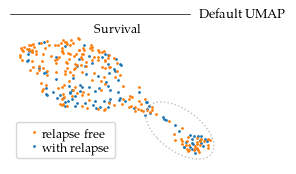

In [7]:
fig = plt.figure(figsize=(base_width, height))
plt.axis('off')
plt.subplots_adjust(0, 0, 1, top)
_title_center = 1+title_center/base_width
fig.add_artist(Line2D(
    [0, _title_center-title_width / 2 / base_width], [0.95, 0.95], 
    lw=0.5, color='k', transform=fig.transFigure
))
plt.text(0.5, title_y, 'Survival', fontsize=9, ha='center', 
         transform=plt.gcf().transFigure)
plt.suptitle('Default UMAP', x=_title_center, fontsize=9.5)
plt.scatter(
    df.obs.x_base[~df.obs.relapsed],
    df.obs.y_base[~df.obs.relapsed],
    1,
    color="tab:orange",
    label="relapse free",
)
plt.scatter(
    df.obs.x_base[df.obs.relapsed],
    df.obs.y_base[df.obs.relapsed],
    1,
    color="tab:blue",
    label="with relapse",
    zorder=0
)
l = plt.legend(
    loc="lower left",
    # title='Survival',
    bbox_to_anchor=(0, 0),
    handletextpad=-0.3,
    labelspacing=0.1,
)
plt.setp(l.get_texts(), va='center')
plt.gca().add_patch(
    Ellipse(
        (8.1, 10.1),
        4,
        2,
        angle=-60,
        fill=False,
        edgecolor='silver',
        linestyle=":",
        clip_on=False,
    )
)
plt.savefig('figures/nki_base_survival.pdf', pad_inches=0)
plt.show()

Base ESR

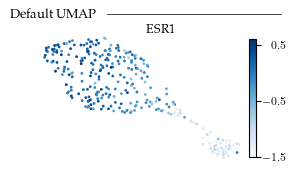

In [97]:
fig = plt.figure(figsize=(bar_width, height))
plt.axis('off')
plt.subplots_adjust(0, 0, 1, top)
_title_center = title_center/bar_width
fig.add_artist(Line2D(
    [_title_center + title_width / 2 / bar_width, 1 - 0.05 / bar_width], [0.95, 0.95], 
    lw=0.5, color='k', transform=fig.transFigure
))
plt.text(0.5, title_y, 'ESR1', fontsize=9, 
        ha='center', transform=plt.gcf().transFigure)
plt.suptitle('Default UMAP', x=_title_center, fontsize=9.5)
plt.scatter(
    df.obs.x_base,
    df.obs.y_base,
    1,
    df.obs.ESR1,
    cmap="Blues",
    vmin=-1.5,
    vmax=0.6,
)
cb = plt.colorbar(pad=0, shrink=0.89, aspect=15)
cb.set_ticks([-1.5, -0.5, 0.5])
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs,ha='right')
cb.ax.tick_params(labelsize=8, pad=18)
# cb.set_label("ESR1", labelpad=-36, y=0.115, fontsize=9)
plt.savefig('figures/nki_base_esr1.pdf', pad_inches=0)
plt.show()

Survival ESR

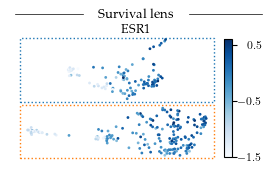

In [107]:
fig = plt.figure(figsize=(bar_width, height))
plt.axis('off')
plt.subplots_adjust(0, 0, 1, top)
fig.add_artist(Line2D(
    [0.05 / bar_width, 0.5 - title_width / 2 / bar_width], [0.95, 0.95], 
    lw=0.5, color='k', transform=fig.transFigure
))
fig.add_artist(Line2D(
    [0.5 + title_width / 2 / bar_width, 1], [0.95, 0.95], 
    lw=0.5, color='k', transform=fig.transFigure
))
plt.text(0.5, title_y, 'ESR1', fontsize=9, 
             ha='center', transform=plt.gcf().transFigure)
plt.suptitle('Survival lens', fontsize=9.5)
plt.scatter(
    df.obs.x_relapsed,
    df.obs.y_relapsed,
    1,
    df.obs.ESR1,
    cmap="Blues",
    vmin=-1.5,
    vmax=0.6,
)
cb = plt.colorbar(pad=0, shrink=0.89, aspect=15)
cb.set_ticks([-1.5, -0.5, 0.5])
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs,ha='right')
cb.ax.tick_params(labelsize=8, pad=18)
# cb.set_label("ESR1", labelpad=-36, y=0.115, fontsize=9)
plt.gca().add_patch(
    Rectangle(
        (-2.1, 1),
        4.2,
        1.2,
        fill=False,
        edgecolor="tab:blue",
        linestyle=":",
        clip_on=False,
    )
)
plt.gca().add_patch(
    Rectangle(
        (-2.1, -0.05),
        4.2,
        1,
        fill=False,
        edgecolor="tab:orange",
        linestyle=":",
        clip_on=False,
    )
)
plt.savefig('figures/nki_survival_esr1.pdf', pad_inches=0)
plt.show()

CSTA survival

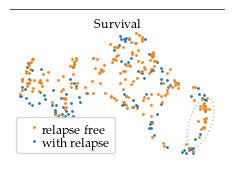

In [9]:
fig = plt.figure(figsize=(base_width, height))
plt.axis('off')
plt.subplots_adjust(0, 0, 1, top)
fig.add_artist(Line2D([0, 1], [0.95, 0.95], lw=0.5, color='k', transform=fig.transFigure))
plt.text(0.5, title_y, 'Survival', fontsize=9, 
             ha='center', transform=plt.gcf().transFigure)
plt.suptitle('', fontsize=9.5)
plt.scatter(
    df.obs.x_CSTA[~df.obs.relapsed],
    df.obs.y_CSTA[~df.obs.relapsed],
    1,
    color="tab:orange",
    label="relapse free",
)
plt.scatter(
    df.obs.x_CSTA[df.obs.relapsed],
    df.obs.y_CSTA[df.obs.relapsed],
    1,
    color="tab:blue",
    label="with relapse",
    zorder=-1
)

l = plt.legend(
    loc="lower left",
    # title='Survival',
    bbox_to_anchor=(0, 0),
    handletextpad=-0.3,
    labelspacing=0.1,
)
plt.setp(l.get_texts(), va='center')
plt.gca().add_patch(
    Ellipse(
        (9.5, 3.2),
        1.8,
        1,
        angle=55,
        fill=False,
        edgecolor="silver",
        linestyle=":",
        clip_on=False,
    )
)
plt.savefig('figures/nki_csta_survival.pdf', pad_inches=0)
plt.show()

CSTA ESR

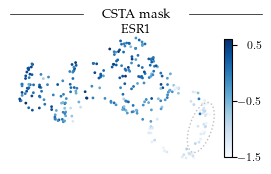

In [115]:
fig = plt.figure(figsize=(bar_width, height))
plt.axis('off')
plt.subplots_adjust(0, 0, 1, top)
fig.add_artist(Line2D(
    [0, 0.5 - title_width / 2 / bar_width], [0.95, 0.95], 
    lw=0.5, color='k', transform=fig.transFigure
))
fig.add_artist(Line2D(
    [0.5 + title_width / 2 / bar_width, 1], [0.95, 0.95], 
    lw=0.5, color='k', transform=fig.transFigure))
plt.text(0.5, title_y, 'ESR1', fontsize=9, 
         ha='center', transform=plt.gcf().transFigure)
plt.suptitle('CSTA mask', fontsize=9.5)
plt.scatter(df.obs.x_CSTA, df.obs.y_CSTA, 1, df.obs.ESR1, 
            cmap="Blues", vmin=-1.5, vmax=0.6)
cb = plt.colorbar(pad=0, shrink=0.89, aspect=15)
cb.set_ticks([-1.5, -0.5, 0.5])
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs,ha='right')
cb.ax.tick_params(labelsize=8, pad=18)
plt.gca().add_patch(
    Ellipse(
        (9.5, 3.2),
        1.8,
        1,
        angle=55,
        fill=False,
        edgecolor="silver",
        linestyle=":",
        clip_on=False,
    )
)
plt.savefig('figures/nki_csta_esr1.pdf', pad_inches=0)
plt.show()

CSTA CSTA

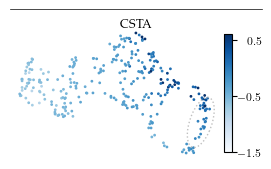

In [116]:
fig = plt.figure(figsize=(bar_width, height))
plt.axis('off')
plt.subplots_adjust(0, 0, 1, top)
fig.add_artist(Line2D([0,1], [0.95, 0.95], lw=0.5, color='k', transform=fig.transFigure))
plt.text(0.5, title_y, 'CSTA', fontsize=9, 
             ha='center', transform=plt.gcf().transFigure)
plt.suptitle('', fontsize=9.5)
plt.scatter(df.obs.x_CSTA, df.obs.y_CSTA, 1, df.obs.CSTA, 
            cmap="Blues", vmin=-1.5, vmax=0.6)
cb = plt.colorbar(pad=0, shrink=0.89, aspect=15)
cb.set_ticks([-1.5, -0.5, 0.5])
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, ha='right')
cb.ax.tick_params(labelsize=8, pad=18)
plt.gca().add_patch(
    Ellipse(
        (9.5, 3.2),
        1.8,
        1,
        angle=55,
        fill=False,
        edgecolor="silver",
        linestyle=":",
        clip_on=False,
    )
)
plt.savefig('figures/nki_csta_csta.pdf', pad_inches=0)
plt.show()